In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from tensorflow import keras
import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

import math
import pickle

In [2]:
spark = SparkSession.builder.appName("DATA-Analysis").getOrCreate()
spark.conf.set('spark.sql.caseSensitive', True)

In [3]:
def prepareData():
    df_list= []

    for root,subdir,files in os.walk("C:/Users/aweso/Downloads/ALL_important/"):
        if len(files)>0:
            for file in files:
                if len(file.split("."))>1 and file.split('.')[-1] == "json":
                    filePath = "/".join((root,file))
                    df = spark.read.format("json").option("inferSchema",True).load(filePath).drop("message_length").toPandas()
                    # Get one hot encoding of columns B
    #                 one_hot = pd.get_dummies(df['type'])
    #                 # Drop column B as it is now encoded
    #                 df = df.drop('type',axis = 1)
    #                 df = df.join(one_hot).groupby('eventid').max()
                    df_list.append(df)

    return pd.concat(df_list)

import math
def datagen(data, kind):
#     "As a generator to produce samples for Keras model"
    batch = []
    for j in range(10,len(data)-1,10):
        # Pick one dataframe from the pool
        if kind=="train":
            if (j//10)%10<7:
#                 print(type())
                df = data[j-10:j]
                df = df.values
                if(not math.isnan(df.sum())):
                    batch.append(df)
        else:
            if (j//10)%10>=7:
                df = data[j-10:j].values
                if(not math.isnan(df.sum())):
                    batch.append(df)
            
    return batch

def datagenBenign(filePath):
    # read benign data
    batch = []
    data = spark.read.format("json").option("inferSchema",True).load(filePath).drop("message_length").toPandas()
    for j in range(10,len(data)-1,10):
        batch.append(data[j-10:j].values)
        
    return np.asanyarray(batch)
    

# Process all malware samples
bigDF =prepareData()
# Batch them by 10 event id sequences
# train = np.array(datagen(bigDF,"train"))
# trainy= np.array([np.array([np.repeat(1.0,10).reshape((-1,1)),np.repeat(0.0,10).reshape((-1,1))]) for i in range(0,train.shape[0])])
test_benign = datagenBenign("C:/Users/aweso/Downloads/ben_lz_all_important/benign3/part-00000-5d4fa1ac-c21e-4ccb-a04f-4d173e78d260-c000.json")
# test_benign = test_benign.reshape(test_benign.shape[0]*test_benign.shape[1],test_benign[2])

In [9]:
display(bigDF)

11_eventwindow  13_eventwindow  16_eventwindow  22_eventwindow  \
0                   0               0               0               1   
1                   0               0               0               1   
2                   0               1               0               1   
3                   0               1               0               1   
4                   0               2               0               1   
...               ...             ...             ...             ...   
12362               0               0               0               0   
12363               0               0               0               0   
12364               0               0               0               0   
12365               0               0               0               0   
12366               0               0               0               0   

       2_eventwindow  eventid_11_timewindowcount  eventid_13_timewindowcount  \
0                  0                           0                           0   
1                  0                           0                           0   
2                  0                           0                           1   
3                  0                           0                           1   
4                  0                           0                           5   
...              ...                         ...                         ...   
12362              0                           0                           0   
12363              0                           0                           0   
12364              0                           0                           0   
12365              0                           0                           0   
12366              0                           0                           0   

       eventid_16_timewindowcount  eventid_22_timewindowcount  \
0                               0                           1   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   
...                           ...                         ...   
12362                           0                           0   
12363                           0                           0   
12364                           0                           0   
12365                           0                           0   
12366                           0                           0   

       eventid_2_timewindowcount  failPresent  invalidPresent  \
0                              0            0               0   
1                              0            0               0   
2                              0            0               0   
3                              0            0               0   
4                              0            0               0   
...                          ...          ...             ...   
12362                          0            0               0   
12363                          0            0               0   
12364                          0            0               0   
12365                          0            0               0   
12366                          0            0               0   

       parentexe_present  parentpid_present  timebetweenfilechange_eventid_2  \
0                      0                  0                             -1.0   
1                      1                  1                             -1.0   
2                      0                  0                             -1.0   
3                      1                  1                             -1.0   
4                      0                  0                             -1.0   
...                  ...                ...                              ...   
12362                  0                  0    

In [8]:
import plotly.express as px
fig = px.histogram(bigDF, x='2_eventwindow' ,nbins=50)
fig.show()

array([[<AxesSubplot:title={'center':'10_eventwindow'}>,
        <AxesSubplot:title={'center':'11_eventwindow'}>,
        <AxesSubplot:title={'center':'12_eventwindow'}>,
        <AxesSubplot:title={'center':'13_eventwindow'}>,
        <AxesSubplot:title={'center':'14_eventwindow'}>,
        <AxesSubplot:title={'center':'15_eventwindow'}>,
        <AxesSubplot:title={'center':'16_eventwindow'}>],
       [<AxesSubplot:title={'center':'17_eventwindow'}>,
        <AxesSubplot:title={'center':'18_eventwindow'}>,
        <AxesSubplot:title={'center':'19_eventwindow'}>,
        <AxesSubplot:title={'center':'1_eventwindow'}>,
        <AxesSubplot:title={'center':'20_eventwindow'}>,
        <AxesSubplot:title={'center':'21_eventwindow'}>,
        <AxesSubplot:title={'center':'22_eventwindow'}>],
       [<AxesSubplot:title={'center':'23_eventwindow'}>,
        <AxesSubplot:title={'center':'24_eventwindow'}>,
        <AxesSubplot:title={'center':'25_eventwindow'}>,
        <AxesSubplot:title={'c

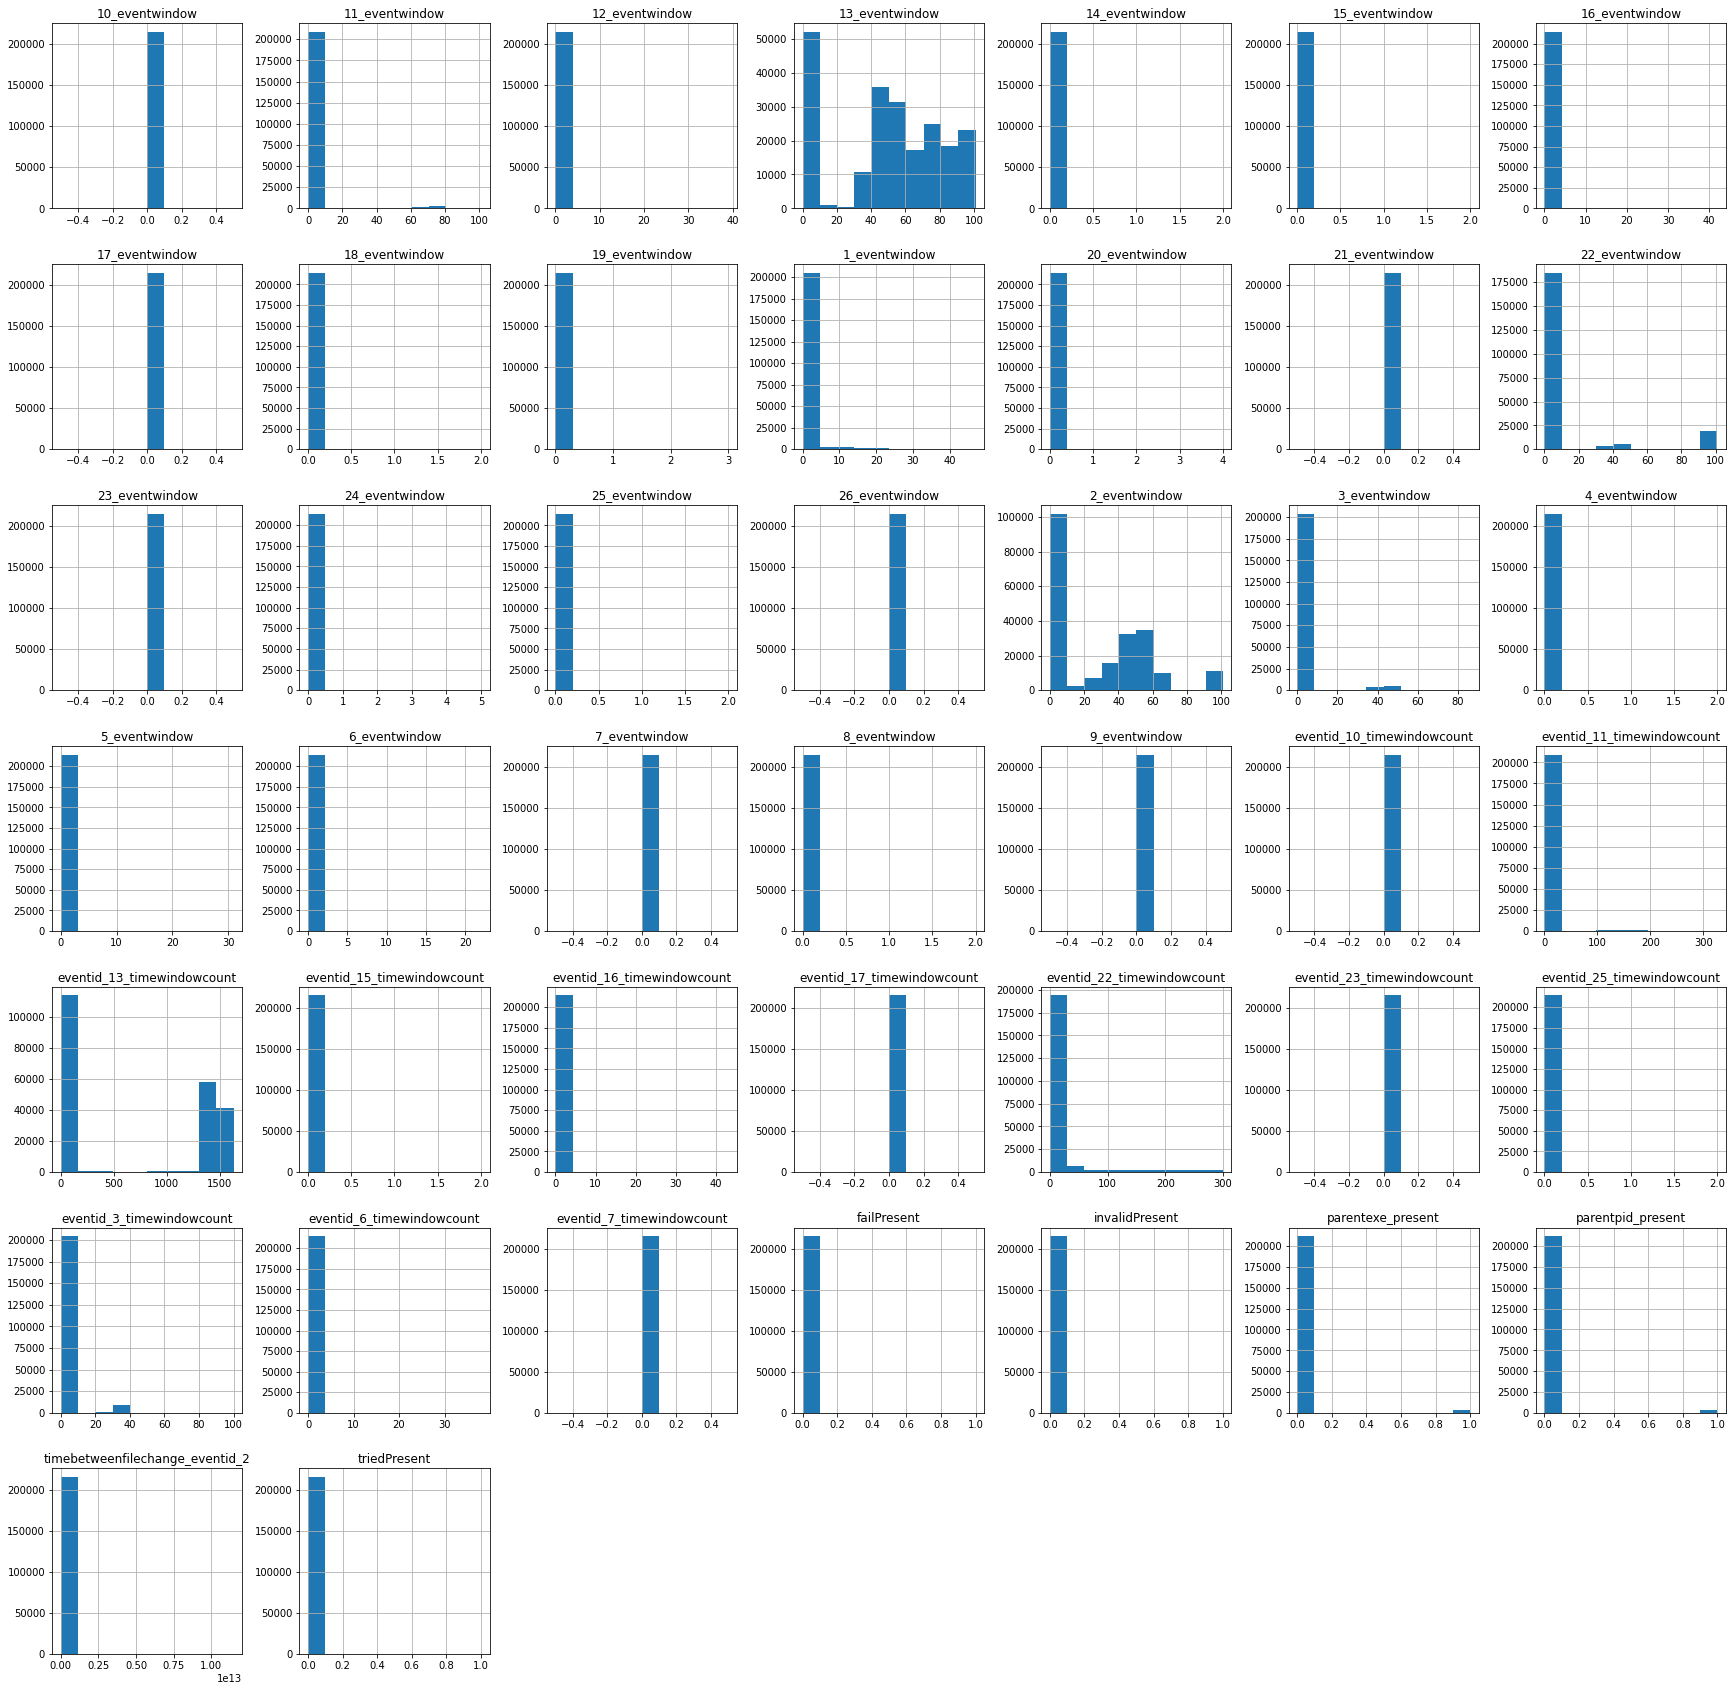

In [26]:
bigDF.hist(figsize=(30,30))

In [13]:
filt = bigDF['eventid_13_timewindowcount'] > 1000 
filtredDF = bigDF[filt]
fig = px.histogram(filtredDF, x="eventid_13_timewindowcount", nbins=50)
fig.show()

In [10]:
# TEST BLOCK
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

test_benign_r = test_benign.reshape(test_benign.shape[0]*test_benign.shape[1],test_benign.shape[2])

# normalize the data
train_r_s = np.nan_to_num(StandardScaler().fit_transform(x_train), nan=0.0)
test_benign_r_s = StandardScaler().fit_transform(test_benign_r)
test_mal = StandardScaler().fit_transform(x_test)

# label the data
ones_DF = pd.DataFrame(data=y_train,columns=["target"])
onesTest_DF = pd.DataFrame(data=y_test,columns=["target"])
zeros = np.array([1.0 for i in range(0,test_benign_r_s.shape[0])])
zeros_DF = pd.DataFrame(data=zeros,columns=["target"])

# PCA reduction
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_r_s)
principalComponentsB = pca.fit_transform(test_benign_r_s)
principalComponentsMalTest = pca.fit_transform(test_mal)

malPCA = pd.DataFrame(data=principalComponents, columns=['PC1','PC2'])
benPCA = pd.DataFrame(data=principalComponentsB, columns=['PC1','PC2'])
malTestPCA = pd.DataFrame(data=principalComponentsMalTest, columns=['PC1','PC2'])

finalMalDF = pd.concat([malPCA,ones_DF], axis=1)
finalBenDF = pd.concat([benPCA,zeros_DF], axis=1)
finalMalTestDF = pd.concat([malTestPCA,onesTest_DF], axis=1)

test_data = pd.concat([finalMalTestDF,finalBenDF],axis=0)

NameError: name 'x_train' is not defined

In [ ]:
finalJoin = pd.concat([finalMalDF,finalBenDF], axis=0)
fig = px.scatter(finalJoin, x='PC1', y='PC2',color='target')
fig.show("notebook")

In [ ]:
fig = px.scatter_3d(test_data,x='PC1',y='PC2',z='PC3',color='target')
fig.show("notebook")